# RHEED Simulation: MgO (001) Surface with <100> Beam

This tutorial demonstrates kinematic RHEED simulation for MgO following the approach in arXiv:2207.06642.

## Experimental Setup:
- **Crystal**: MgO (magnesium oxide, rock salt structure)
- **Surface**: (001) orientation
- **Beam direction**: <100> (along x-axis)
- **Electron energy**: 20 keV
- **Grazing angle**: 2°

## Expected Pattern:
For MgO (001) with <100> beam, we expect:
- Vertical streaks perpendicular to the beam
- Mirror symmetry about the vertical axis
- Streak spacing determined by surface reciprocal lattice

In [5]:
import jax.numpy as jnp
import rheedium as rh

### Use `autoreload` to reload changed modules, you may disable this for normal use.

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
structure_file = rh.inout.parse_cif("../tests/test_data/MgO.cif")

In [8]:
structure_file

CrystalStructure(frac_positions=Array([[ 0. ,  0. ,  0. , 12. ],
       [ 0. ,  0. ,  0.5,  8. ]], dtype=float64), cart_positions=Array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+01],
       [1.30317238e-16, 1.30317238e-16, 2.12824200e+00, 8.00000000e+00]],      dtype=float64), cell_lengths=Array([4.256484, 4.256484, 4.256484], dtype=float64), cell_angles=Array([90., 90., 90.], dtype=float64))

In [9]:
# MgO (001) surface with <100> beam direction
# The CIF file already has (001) as the surface (z-direction)
# For RHEED: beam along <100> direction (x-axis) at grazing angle

zone_axis = jnp.array([0, 0, 1])  # (001) surface normal
beam_direction = jnp.array([1, 0, 0])  # <100> beam along x-axis

# Now, load the parameters

In [21]:
# RHEED simulation parameters for MgO (001) surface, <100> beam
voltage_kV = 10.0  # Electron beam voltage in kV (typical for RHEED)
theta_deg = 2.0  # Grazing angle (1-3 degrees typical for RHEED)
phi_deg = 0.0  # Beam along x-axis (<100> direction)
hmax, kmax, lmax = 4, 4, 2  # Reciprocal lattice indexing bounds
detector_distance = 80.0  # Detector distance in mm (typical RHEED geometry)
tolerance = 0.05  # Tolerance for Ewald sphere intersection

# Now, we will process things step by step.

## Electron wavelength (Å)

In [22]:
lam_ang = rh.simul.wavelength_ang(voltage_kV)
lam_ang

Array(0.12200456, dtype=float64, weak_type=True)

## Build real-space lattice vectors

In [23]:
cell_vectors = rh.ucell.build_cell_vectors(
    *structure_file.cell_lengths, *structure_file.cell_angles
)

In [24]:
cell_vectors

Array([[4.25648400e+00, 0.00000000e+00, 0.00000000e+00],
       [2.60634475e-16, 4.25648400e+00, 0.00000000e+00],
       [2.60634475e-16, 2.60634475e-16, 4.25648400e+00]], dtype=float64)

## Generate reciprocal lattice vectors

In [25]:
Gs = rh.ucell.generate_reciprocal_points(
    crystal=structure_file, hmax=hmax, kmax=kmax, lmax=lmax, in_degrees=True
)
Gs

Array([[-5.90457787e+00, -5.90457787e+00, -2.95228893e+00],
       [-5.90457787e+00, -5.90457787e+00, -1.47614447e+00],
       [-5.90457787e+00, -5.90457787e+00,  7.23102239e-16],
       ...,
       [ 5.90457787e+00,  5.90457787e+00, -7.23102239e-16],
       [ 5.90457787e+00,  5.90457787e+00,  1.47614447e+00],
       [ 5.90457787e+00,  5.90457787e+00,  2.95228893e+00]],      dtype=float64)

## Incident wavevector

In [26]:
k_in = rh.simul.incident_wavevector(lam_ang, theta_deg)
k_in

Array([51.46822109,  0.        , -1.79730988], dtype=float64)

## Allowed reflections by kinematic scattering conditions

In [27]:
allowed_indices, k_out = rh.simul.find_kinematic_reflections(
    k_in=k_in,
    gs=Gs,
    tolerance=tolerance,
)
allowed_indices, k_out

(Array([199, 204, 209], dtype=int64),
 Array([[51.46822109, -1.47614447,  1.15497905],
        [51.46822109,  0.        ,  1.15497905],
        [51.46822109,  1.47614447,  1.15497905]], dtype=float64))

### Simulate RHEED pattern for MgO (001) surface with <100> beam
### Using the paper's kinematic approach

In [28]:
# Generate RHEED pattern for MgO (001) with <100> beam using paper's approach
pattern_001_100 = rh.simul.kinematic_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    lmax=lmax,
    tolerance=tolerance,
    detector_distance=detector_distance,
)
pattern_001_100

RHEEDPattern(G_indices=Array([199, 204, 209], dtype=int32), k_out=Array([[51.46822109, -1.47614447,  1.15497905],
       [51.46822109,  0.        ,  1.15497905],
       [51.46822109,  1.47614447,  1.15497905]], dtype=float64), detector_points=Array([[-2.29445578,  1.79525   ],
       [ 0.        ,  1.79525   ],
       [ 2.29445578,  1.79525   ]], dtype=float64), intensities=Array([400., 400., 400.], dtype=float64))

## Check how many reflections were found

In [29]:
print(f"Number of allowed reflections: {len(pattern_001_100.intensities)}")
print(f"Shape of detector points: {pattern_001_100.detector_points.shape}")
print(f"Intensity range: [{pattern_001_100.intensities.min():.2e}, {pattern_001_100.intensities.max():.2e}]")
print("\nFirst few reflections:")
print("Detector coords (x, y) [mm]:")
print(pattern_001_100.detector_points[:5])

Number of allowed reflections: 3
Shape of detector points: (3, 2)
Intensity range: [4.00e+02, 4.00e+02]

First few reflections:
Detector coords (x, y) [mm]:
[[-2.29445578  1.79525   ]
 [ 0.          1.79525   ]
 [ 2.29445578  1.79525   ]]


## Visualize the RHEED pattern

The pattern should show vertical streaks characteristic of RHEED from (001) surface with <100> beam.

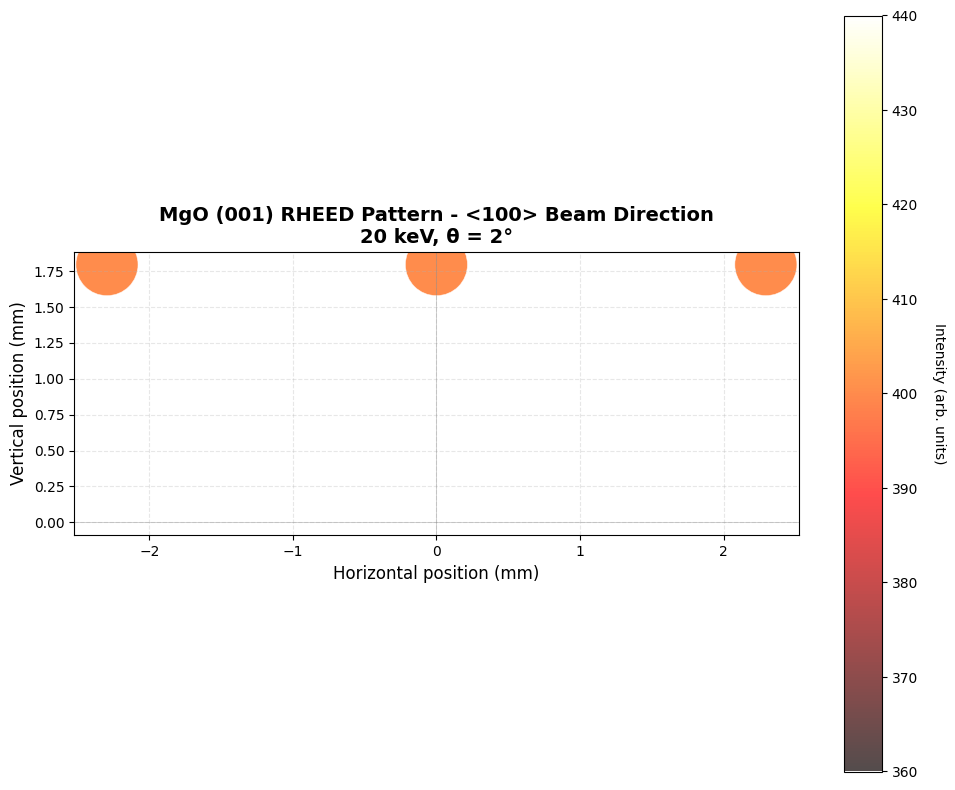

In [30]:
import matplotlib.pyplot as plt

# Plot the RHEED pattern
fig, ax = plt.subplots(figsize=(10, 8))

# Plot diffraction spots
scatter = ax.scatter(
    pattern_001_100.detector_points[:, 0],
    pattern_001_100.detector_points[:, 1],
    s=pattern_001_100.intensities * 5,  # Size proportional to intensity
    c=pattern_001_100.intensities,  # Color by intensity
    cmap='hot',
    alpha=0.7,
    edgecolors='white',
    linewidths=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Intensity (arb. units)', rotation=270, labelpad=20)

# Labels and formatting
ax.set_xlabel('Horizontal position (mm)', fontsize=12)
ax.set_ylabel('Vertical position (mm)', fontsize=12)
ax.set_title('MgO (001) RHEED Pattern - <100> Beam Direction\n20 keV, θ = 2°', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Understanding the MgO (001) RHEED Pattern

## Geometry:
- **Surface**: MgO (001) - square lattice with a = 4.21 Å
- **Beam direction**: <100> along x-axis at grazing angle θ = 2°
- **Expected pattern**: Vertical streaks perpendicular to beam direction

## Key features to expect:
1. **Symmetry**: Pattern should show mirror symmetry about vertical axis
2. **Streaks**: Vertical rods due to limited perpendicular momentum transfer
3. **Spacing**: Streak separation ∝ 1/a where a is the surface lattice constant
4. **Intensities**: Determined by structure factors (Mg²⁺ and O²⁻ positions)

## MgO Structure:
- Rock salt structure (fcc)
- (001) surface: alternating Mg and O atoms in square lattice
- For <100> beam: should see (0k) reflections as vertical streaks